## 텍스트 증강데이터로 학습한 baseline, attention, pretrainedEmb 3가지 모델에 대해 앙상블 수행

In [1]:
!pip install -r "/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.8 MB/s eta 0:00:00
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=1de672ff394ee9d2ba7139c5c9af622c738da80175ed858593e6e72eaa681689
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [2]:
from tensorflow.keras.layers import Layer
import os
import sys
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pickle

sys.path.append('/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong') # 모듈경로 추가
from utils.preprocessing import *
from utils.models import *

import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 00_jw (jiwoong-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# 커스텀 어텐션 층을 읽기 전에 한 번 정의
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [4]:
# 저장된 모델 불러오기
model_pretrained_emb = load_model('/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/models/model_pretrained_emb_aug_synonym.keras')
model_attention = load_model('/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/models/model_attention_aug_synonym.keras', custom_objects={"AttentionLayer": AttentionLayer})
model_baseline = load_model('/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/models/baseline_aug_synonym.keras')

In [5]:
# 검증 데이터 불러오기
with open('/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/data/preprocessed_data_aug_synonym.pkl', 'rb') as f:
    data = pickle.load(f)
    X_val = data['X_val']
    y_val = data['y_val']

## 소프트 보팅

In [6]:
ordered_columns = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'] # kaggle에 명시된 순서로 재배치

# W&B 프로젝트 초기화
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="jiwoong-team",
    # Set the wandb project where this run will be logged.
    project="DLThon-DKTC",
    # Track hyperparameters and run metadata.
    name=f"BiLSTM_aug_synonym_ensemble_soft", # 실험 이름
    notes="aug_synonym으로 학습한 baseline, attention, pretrainedEmb 모델 3개를 앙상블(소프트 보팅)", # 실험에 대한 간단한 설명
    config={ # 세부 구성 내용
        "experiment_name": "BiLSTM_aug_synonym_ensemble_soft",
        "general_conversation_type": "LLM에서 생성한 대화 데이터", # 일반 데이터 타입
        "architecture": "BiLSTM(64), Ensemble",
    },
)

y_pred1 = model_baseline.predict(X_val)
y_pred2 = model_attention.predict(X_val)
y_pred3 = model_pretrained_emb.predict(X_val)

# 예측 결과
y_pred_ensemble = (y_pred1 + y_pred2 + y_pred3) / 3
final_preds = np.argmax(y_pred_ensemble, axis=1)
# 실제 결과
y_true_labels = np.argmax(y_val, axis=1)

c = np.argmax(y_pred1, axis=1)


# wandb Table 생성
report = classification_report(y_true_labels, final_preds, target_names=ordered_columns, output_dict=True)
columns = ["class", "precision", "recall", "f1-score", "support"]
data = []

for label, metrics in report.items():
    if isinstance(metrics, dict):  # dict일 때만 values 가져오기
        row = [label] + [metrics.get(col, None) for col in columns[1:]]
        data.append(row)

table = wandb.Table(columns=columns, data=data)

# wandb에 훈련 결과 기록
wandb.log({
    "classification_report_table": table,
    "macro_f1": report["macro avg"]["f1-score"],
    "accuracy": report["accuracy"],
    "threat_f1": report["협박 대화"]["f1-score"],
    "extortion_f1": report["갈취 대화"]["f1-score"],
    "workplace_bullying_f1": report["직장 내 괴롭힘 대화"]["f1-score"],
    "other bullying": report["기타 괴롭힘 대화"]["f1-score"],
    "general_conversation_f1": report["일반 대화"]["f1-score"],
})

# run.finish()

print(confusion_matrix(y_true_labels, c))
print(classification_report(y_true_labels, c, target_names=ordered_columns))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[153   9   5  11   1]
 [  5 178   3   9   0]
 [  1   0 187   5   1]
 [  7   5  12 178   0]
 [  0   1   1   0 156]]
              precision    recall  f1-score   support

       협박 대화       0.92      0.85      0.89       179
       갈취 대화       0.92      0.91      0.92       195
 직장 내 괴롭힘 대화       0.90      0.96      0.93       194
   기타 괴롭힘 대화       0.88      0.88      0.88       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928



## 하드보팅

In [7]:
# W&B 프로젝트 초기화
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="jiwoong-team",
    # Set the wandb project where this run will be logged.
    project="DLThon-DKTC",
    # Track hyperparameters and run metadata.
    name=f"BiLSTM_aug_synonym_ensemble_hard", # 실험 이름
    notes="aug_synonym으로 학습한 baseline, attention, pretrainedEmb 모델 3개를 앙상블(하드 보팅)", # 실험에 대한 간단한 설명
    config={ # 세부 구성 내용
        "experiment_name": "BiLSTM_aug_synonym_ensemble_hard",
        "general_conversation_type": "LLM에서 생성한 대화 데이터", # 일반 데이터 타입
        "architecture": "BiLSTM(64), Ensemble",
    },
)

pred1 = np.argmax(model_baseline.predict(X_val), axis=1)
pred2 = np.argmax(model_attention.predict(X_val), axis=1)
pred3 = np.argmax(model_pretrained_emb.predict(X_val), axis=1)

# 예측 결과
stacked = np.stack([pred1, pred2, pred3], axis=1)
final_preds = [np.bincount(row).argmax() for row in stacked]

# wandb Table 생성
report = classification_report(y_true_labels, final_preds, target_names=ordered_columns, output_dict=True)
columns = ["class", "precision", "recall", "f1-score", "support"]
data = []

for label, metrics in report.items():
    if isinstance(metrics, dict):  # dict일 때만 values 가져오기
        row = [label] + [metrics.get(col, None) for col in columns[1:]]
        data.append(row)

table = wandb.Table(columns=columns, data=data)

# wandb에 훈련 결과 기록
wandb.log({
    "classification_report_table": table,
    "macro_f1": report["macro avg"]["f1-score"],
    "accuracy": report["accuracy"],
    "threat_f1": report["협박 대화"]["f1-score"],
    "extortion_f1": report["갈취 대화"]["f1-score"],
    "workplace_bullying_f1": report["직장 내 괴롭힘 대화"]["f1-score"],
    "other bullying": report["기타 괴롭힘 대화"]["f1-score"],
    "general_conversation_f1": report["일반 대화"]["f1-score"],
})

run.finish()

print(confusion_matrix(y_true_labels, final_preds))
print(classification_report(y_true_labels, final_preds, target_names=ordered_columns))

accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other bullying,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.93642
extortion_f1,0.92621
general_conversation_f1,0.99367
macro_f1,0.93785


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other bullying,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.93319
extortion_f1,0.92583
general_conversation_f1,0.99367
macro_f1,0.93484


[[156   9   3  10   1]
 [  6 181   2   6   0]
 [  2   0 188   4   0]
 [  6   5   7 184   0]
 [  0   1   0   0 157]]
              precision    recall  f1-score   support

       협박 대화       0.92      0.87      0.89       179
       갈취 대화       0.92      0.93      0.93       195
 직장 내 괴롭힘 대화       0.94      0.97      0.95       194
   기타 괴롭힘 대화       0.90      0.91      0.91       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.93       928
   macro avg       0.94      0.93      0.93       928
weighted avg       0.93      0.93      0.93       928



## Submission

In [8]:
import pickle
# aug 토크나이저 로드
with open("/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/notebooks/jiwoong/data/tokenizer_aug_synonym.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [9]:
import os
import pandas as pd
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13/data/raw_csv/test.csv'

df_test = pd.read_csv(test_csv_path)
conversations_test = df_test['text'].to_list()

X_text = preprocessing(conversations_test, tokenizer, 350)

In [10]:
pred1 = np.argmax(model_baseline.predict(X_text), axis=1)
pred2 = np.argmax(model_attention.predict(X_text), axis=1)
pred3 = np.argmax(model_pretrained_emb.predict(X_text), axis=1)

# 예측 결과
stacked = np.stack([pred1, pred2, pred3], axis=1)
final_preds = [np.bincount(row).argmax() for row in stacked]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [11]:
# id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': df_test['idx'],
    'class': final_preds
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('/content/submission2.csv', index=False)

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,4
4,t_004,3
...,...,...
495,t_495,2
496,t_496,1
497,t_497,1
498,t_498,0


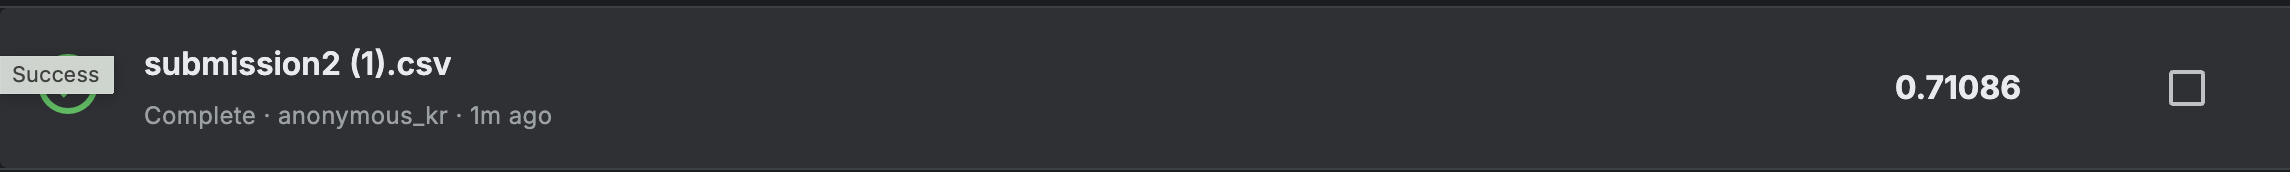